In [1]:
# https://github.com/NVIDIA/accelerated-computing-hub/blob/32fe3d5a448446fd52c14a6726e1b867cbfed2d9/Accelerated_Python_User_Guide/notebooks/Chapter_12_Intro_to_NVIDIA_Warp.ipynb
import warp as wp

wp.init()

Warp 1.11.0 initialized:
   CUDA Toolkit 12.9, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3060 Laptop GPU" (6 GiB, sm_86, mempool enabled)
   Kernel cache:
     /home/thanhnv154te/.cache/warp/1.11.0


A Particle simulation example in Warp


Basic Warp program that solves for the motion of a group of particles under the influence of gravity $g$ and non-gravitational force $f_n$

The update equations are:
$$a_n = f_n / m + g$$
$$v_{n+1} = v_{n} + a_{n} \Delta{t}$$
$$x_{n+1} = x_{n} + v_{n+1} \Delta{t}$$

We will assume a simple drag force $f_n = -b v_{n}$

The particles positions and velocitices will be intitialized to random values


In [2]:
import numpy as np
import warp as wp

num_particles = 10_000_000 
num_steps = 100

mass = 0.1  # Mass per particle [kg]
g = 9.81  # Gravitational acceleration [m/s^2]
b = 0.05  # Drag Coefficient [kg/s]

dt = 0.01 * (2 * mass / b)

gravity = wp.vec3([0.0, 0.0, -g])

# Initial positions: random values between -1.0 and 1.0 for x, y, and z
rng = np.random.default_rng(12345)
positions_np = rng.uniform(low=-1.0, high=1.0, size=(num_particles, 3))
positions = wp.array(positions_np, dtype=wp.vec3)

# Initial velocities: random values between -0.5 and 0.5 m/s for vx, vy, and vz
velocities_np = rng.uniform(low=-0.5, high=0.5, size=(num_particles, 3))
velocities = wp.array(velocities_np, dtype=wp.vec3)


@wp.kernel
def integrate(positions: wp.array(dtype=wp.vec3), velocities: wp.array(dtype=wp.vec3)):
    i = wp.tid()

    acceleration = (-b * velocities[i]) / mass + gravity
    velocities[i] += acceleration * dt
    positions[i] += velocities[i] * dt


for step in range(num_steps):
    wp.launch(integrate, dim=(num_particles,), inputs=[positions, velocities])

print(f"Final positions: {positions}")

Module __main__ f3483db load on device 'cuda:0' took 3.50 ms  (cached)
Final positions: [[ -0.09391715  -1.0830888  -43.828407  ]
 [  0.6937012   -0.6013651  -45.414093  ]
 [  0.5957543    0.08006047 -44.8957    ]
 ...
 [ -0.72598     -0.8991223  -45.298027  ]
 [ -0.32058033   0.70321625 -43.714462  ]
 [ -0.08150801  -0.0732362  -46.081345  ]]


In [3]:
%%writefile Chapter_12_finite_difference.py

import warp as wp
import numpy as np
import os

wp.config.kernel_cache_dir = os.path.join(
    os.path.dirname(os.path.realpath(__file__)), "Chapter_12_finite_difference_example_cache"
)


@wp.kernel
def finite_difference(dx: float, u: wp.array(dtype=float), u_out: wp.array(dtype=float)):
    i = wp.tid()
    total_points = u.shape[0]
    u_out[i] = (
        u[(i + 1) % total_points] - 2.0 * u[i] + u[(i - 1 + total_points) % total_points]
    ) / (dx * dx)


sin_array_np = np.sin(np.linspace(0, 2 * np.pi, 1024))
sin_array_wp = wp.array(sin_array_np, dtype=float)

u_out_wp = wp.empty_like(sin_array_wp)

dx = 2 * np.pi / 1024

wp.launch(finite_difference, sin_array_wp.shape, inputs=[dx, sin_array_wp], outputs=[u_out_wp])

print(f"{sin_array_wp.numpy()=}")
print(f"{u_out_wp.numpy()=}")

Overwriting Chapter_12_finite_difference.py


In [4]:
!python Chapter_12_finite_difference.py

Warp 1.11.0 initialized:
   CUDA Toolkit 12.9, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3060 Laptop GPU" (6 GiB, sm_86, mempool enabled)
   Kernel cache:
     /media/thanhnv154te/15a388e9-5b07-4e1c-b175-72e9839b5c872/workspace/physic-simulation/warp_samples/Chapter_12_finite_difference_example_cache
Module __main__ d3dcac8 load on device 'cuda:0' took 4.48 ms  (cached)
sin_array_wp.numpy()=array([ 0.0000000e+00,  6.1418824e-03,  1.2283533e-02, ...,
       -1.2283533e-02, -6.1418824e-03, -2.4492937e-16],
      shape=(1024,), dtype=float32)
u_out_wp.numpy()=array([ 1.6313293e+02, -6.1594173e-03, -1.2269361e-02, ...,
        1.2269361e-02,  6.1594173e-03, -1.6313293e+02],
      shape=(1024,), dtype=float32)


In [5]:
@wp.kernel
def basic_4d_kernel():
    i, j, k, w = wp.tid()
    wp.printf("(%d,%d,%d,%d)\n", i, j, k, w)


wp.launch(basic_4d_kernel, (2, 2, 2, 2))

Module __main__ 4d4f61d load on device 'cuda:0' took 997.31 ms  (compiled)


In [6]:
@wp.func
def square(x: float):
    return x * x


@wp.kernel
def test_kernel(x: wp.array(dtype=float), y: wp.array(dtype=float)):
    i = wp.tid()

    y[i] = square(x[i])


x = wp.full((10,), value=10.0, dtype=float)
y = wp.empty_like(x)

wp.launch(test_kernel, x.shape, inputs=[x], outputs=[y])

print(y.numpy())

(0,0,0,0)
(0,0,0,1)
(0,0,1,0)
(0,0,1,1)
(0,1,0,0)
(0,1,0,1)
(0,1,1,0)
(0,1,1,1)
(1,0,0,0)
(1,0,0,1)
(1,0,1,0)
(1,0,1,1)
(1,1,0,0)
(1,1,0,1)
(1,1,1,0)
(1,1,1,1)
Module __main__ 2e71201 load on device 'cuda:0' took 534.28 ms  (compiled)
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


Module __main__ 735d5ce load on device 'cuda:0' took 631.21 ms  (compiled)


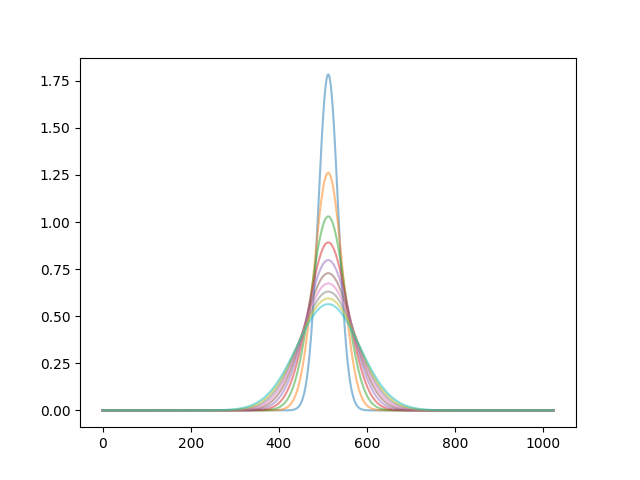

In [7]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import warp as wp


@wp.struct
class SimParameters:
    nx: int
    dx: float 
    dt: float 
    alpha: float 

sim_params = SimParameters()
sim_params.nx = 1024
sim_params.dx = 0.1
sim_params.alpha = 0.01
sim_params.dt = 0.5 * (sim_params.dx * sim_params.dx) / (2 * sim_params.alpha)


u_np = np.zeros(sim_params.nx)

# Set initial condition: heat in the middle
u_np[sim_params.nx // 2] = 100

u = wp.array(u_np, dtype=float)
u_new = wp.zeros(sim_params.nx, dtype=float)


@wp.kernel
def update(sim_params: SimParameters, u: wp.array(dtype=float), u_new: wp.array(dtype=float)):
    i = wp.tid()

    if (i > 0) and (i < sim_params.nx - 1):
        u_new[i] = u[i] + sim_params.alpha * sim_params.dt * (u[i + 1] - 2.0 * u[i] + u[i - 1]) / (
            sim_params.dx * sim_params.dx
        )


fig, ax = plt.subplots()

for step_index in range(10000):
    wp.launch(update, (sim_params.nx,), inputs=[sim_params, u, u_new])
    (u, u_new) = (u_new, u)

    if (step_index + 1) % 1000 == 0:
        ax.plot(u.numpy(), label=f"{step_index}", alpha=0.5)  

In [8]:
import math


def f_grad(x):
    return (
        x * x * x * x / (1 - x * x) ** (3 / 2)
        + 3 * x * x / math.sqrt(1 - x * x)
        + 2 * x * math.log(x) * math.cos(x * x)
        + math.sin(x * x) / x
    )


print(f_grad(0.5))

0.7854594538401802


In [9]:
def f(x):
    return math.sin(x * x) * math.log(x) + x * x * x / math.sqrt(1.0 - x * x)


h = 1e-8

f_deriv = (f(0.5 + h) - f(0.5)) / h

print(f_deriv)

0.7854594891165689


In [10]:
@wp.func
def f(x: wp.float64):
    return wp.sin(x * x) * wp.log(x) + x * x * x / wp.sqrt(wp.float64(1.0) - x * x)


@wp.kernel
def compute(x: wp.array(dtype=wp.float64), out: wp.array(dtype=wp.float64)):
    i = wp.tid()
    out[i] = f(x[i])


x = wp.full((1,), value=0.5, dtype=wp.float64, requires_grad=True)
out = wp.empty(1, dtype=wp.float64, requires_grad=True)

with wp.Tape() as tape:
    wp.launch(compute, (1,), inputs=[x, out])

tape.backward(loss=out)

print(x.grad.numpy()[0])

Module __main__ 4191738 load on device 'cuda:0' took 932.59 ms  (compiled)
0.7854594538401803
